In [10]:
# This script loads images from girder, tracks nuclei, and saves the tracks back to girder as annotations.
# each frame gets a track up to that time.
# TODO: Save a single track used by all frames.

from __future__ import division, print_function
from ipywidgets import interact, interactive, fixed, interact_manual    
import ipywidgets as widgets
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import scipy as sp
from scipy import ndimage
from IPython.core.debugger import set_trace
import cv2
import sys
from pprint import pprint
from random import randint
from nuclei.foci import *
import nuclei.girder as g
import nuclei.girder.time_lapse_data as reader

plt.rcParams['image.cmap'] = 'gist_earth'
matplotlib.rcParams['figure.figsize'] = (11.0, 11.0)




{'updated': '2018-03-19T00:23:10.535000+00:00', 'baseParentType': 'user', 'folderId': '5aaf02871fbb9006233ae6a3', 'description': '', 'baseParentId': '58c2f245dd98b50cb309c624', 'created': '2018-03-19T00:23:10.535000+00:00', 'creatorId': '58c02d28dd98b5045cc61e65', 'name': 'time0090', 'size': 2546575, 'largeImage': {'sourceName': 'pil', 'fileId': '5aaf02ef1fbb9006233ae7b5'}, '_modelType': 'item', '_id': '5aaf02ee1fbb9006233ae7b3'}


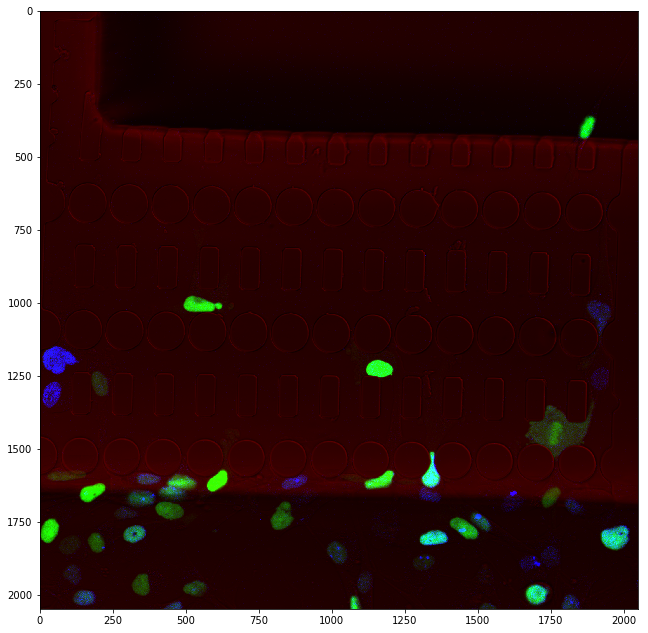

In [11]:
# This block is just a demo of the time_lapse_data. The source object is used in the rest of the notebook.

# Hard coded to folder ids
# TODO: Iterate over series in a folder.
# /Gwenda/LawDNADamageFociData
# 5aaf02831fbb9006233ae6a2  073117 BT549_Sv40_Bt549_SV40 NLS GFP 53BP1 mcherry_2017_07_31__18_31_54
#    series000: 5aaf02871fbb9006233ae6a3
#    ...
# 5a95b8361fbb904fdd27d09a  080217 BT549 NLS GFP 53BP1 mcherry_2017_08_02__17_46_03
# 5aaec5d21fbb9006233ad700  080817 BT549 NLS GFP 53BP1 mcherry_2017_08_08__17_27_10

# this function is defined in foci.py
# 073117 BT549_Sv40_Bt549_SV40 NLS GFP 53BP1 mcherry_2017_07_31__18_31_54/series000
# 92 time steps in this series (pattern "time%04d"%idx )
# three shannels are read into a single image (BGR)
# Looks like the brightfield channel is the first (0)
source = reader.time_lapse_data()
# 073117 BT549_Sv40_Bt549_SV40 NLS GFP 53BP1 mcherry_2017_07_31__18_31_54series000
source.load('5aaf02831fbb9006233ae6a2')
num_series = source.get_number_of_series()
series_idx = 2
num_time_steps = source.get_series_length(series_idx)
im, item_obj = source.get_image(0,90)

print(item_obj)
plt.imshow(im)




(2048, 2048, 3)


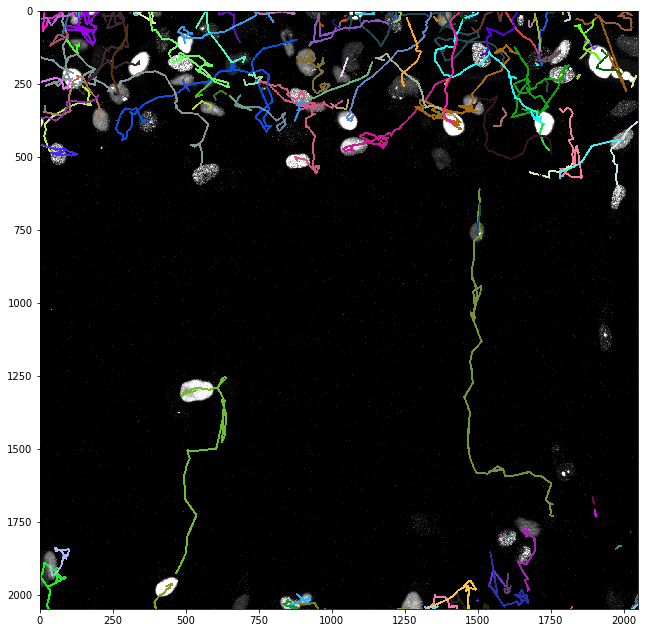

In [12]:
prev_frame_ellipses = None
# union of all lines from all frames.
# this will be an array of lines.  A line will be an array of points.  a point will be 3 (int, int, int)
tracks = []
# Save the image ids so we can upload the tracks to girder
item_ids = []

# Chain the lein segments so we get "polylines" as a series of points in arrays
img1, img_info = source.get_image(series_idx,0)
item_ids.append(img_info['_id'])
img_bw = img1.copy()
img_bw[:,:,0] = np.maximum(img1[:,:,1], img1[:,:,2])
img_bw[:,:,1] = img_bw[:,:,0]
img_bw[:,:,2] = img_bw[:,:,0]
img1 = img_bw
print(img1.shape)
ellipses1 = find_cell_ellipses(img1)
for t in range(1,num_time_steps):
    img2, img_info = source.get_image(series_idx, t)
    item_ids.append(img_info['_id'])
    img_bw = img2.copy()
    img_bw[:,:,0] = np.maximum(img2[:,:,1], img2[:,:,2])
    img_bw[:,:,1] = img_bw[:,:,0]
    img_bw[:,:,2] = img_bw[:,:,0]
    img2 = img_bw
    ellipses2 = find_cell_ellipses(img2)
    ellipse_pairs = match_ellipses(ellipses1, ellipses2)
    
    # lnsegs are the line segments we want to add to our poly lines.
    for pair in ellipse_pairs:
        track = find_track_that_ends_with_ellipse(tracks, pair[0])
        if not track:
            # The line doe not exist. This is the first line segment.
            # make a line wit a single point (the start)
            track = Track()
            track.add_ellipse(pair[0], t-1)
            tracks.append(track)
        # We found the line that ends with the new segment's first point.
        # Add the second point to the line
        track.add_ellipse(pair[1], t)
    img1 = img2
    ellipses1 = ellipses2

tmp = img2.copy()
for track in tracks:
    track.draw_in_frame(tmp, num_time_steps)
plt.imshow(tmp)

In [13]:
print(len(tracks))
combined_tracks = []
while len(tracks) > 0:
    # Either we are finished merging track 1, or it gets merged with track2.
    # Either way, it is removed from the list of tracks.
    track1 = tracks.pop()
    track2 = find_best_track_to_merge(track1, tracks)
    if track2 == None:
        combined_tracks.append(track1)
    else:
        track2.merge_track(track1)

g.upload_tracks(combined_tracks, item_ids)

print(len(combined_tracks))
saved_tracks = combined_tracks

124
58


In [14]:
# This function writes out images for training.
def save_tracking_video_frames(combined_tracks, source, series_idx, out_dir):
    for track in combined_tracks:
        for time in range(track.get_start_time()+1,track.get_end_time()):
            print(time)
            currentimg, _ = source.get_image(series_idx,time)
            previmg, _ = source.get_image(series_idx,time-1)
            prevellipse = track.get_ellipse_from_time(time-1)
            if prevellipse != None:
                # This uses data dir it will not work.
                # TODO: fix it.
                prevellipsemask = make_ellipse_mask(prevellipse,time-1,data_dir)
                centx = int(prevellipse[0][0])
                centy = int(prevellipse[0][1])
                croppedcurrent = currentimg[centy-150:centy+150, centx-150:centx+150, :]
                croppedprev = previmg[centy-150:centy+150, centx-150:centx+150, :]
                croppedmask = prevellipsemask[centy-150:centy+150, centx-150:centx+150, :]
                cv2.imwrite(out_dir + "channel1time%dcurrent.png"%time, croppedcurrent)
                cv2.imwrite(out_dir + "channel1time%dprev.png"%time, croppedprev)
                cv2.imwrite(out_dir + "channel1time%dprevmask.png"%time, croppedmask)


        
